## Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd /content/drive/MyDrive/GRM_proj/src/

Mounted at /content/drive
/content/drive/MyDrive/GRM_proj/src


In [2]:
!pip install PyMaxflow

In [3]:
# import os
# import sys
# sys.path.insert(0, "../")

In [4]:
from PIL import Image
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from time import perf_counter

In [5]:
from energy import style_transfer
import graph_cut as gc
from maxflow.fastmin import aexpansion_grid

## Data

Content shape :  (128, 128, 3)
Style shape :  (128, 128, 3)


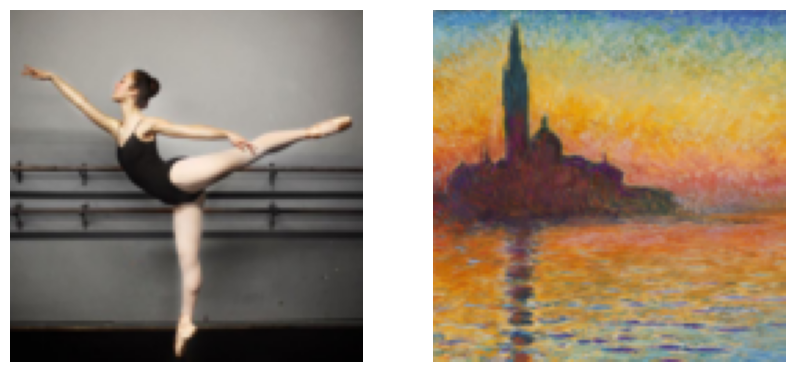

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name, for_plot=True):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    if for_plot:
      image = image.cpu().numpy().transpose(1,2,0)
    return image

content_img = image_loader("../data/images/dance2.png")
style_img = image_loader("../data/images/monnet.png")

print("Content shape : ",content_img.shape)
print("Style shape : ",style_img.shape)


def plot_2_images(content, style):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(content)
    ax[0].axis('off')
    ax[1].imshow(style)
    ax[1].axis('off')
    plt.show();

plot_2_images(content_img,style_img)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Transfered features shape :  torch.Size([3, 128, 128])


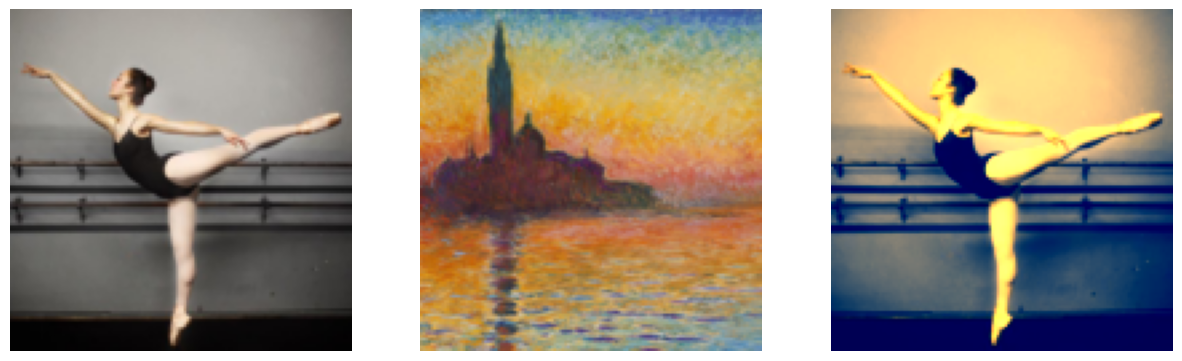

In [7]:
def plot_3_images(target, initial, assigned):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(target)
    ax[0].axis('off')
    ax[1].imshow(initial)
    ax[1].axis('off')
    ax[2].imshow(assigned)
    ax[2].axis('off')
    plt.show();

#style transfer
transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=0.2, lambd=0.5, k=3)
print("Transfered features shape : ",transfered_features.shape)
plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

## Alpha expansion

Distance array shape :  (3, 128, 128)
Distance image shape :  (128, 128)


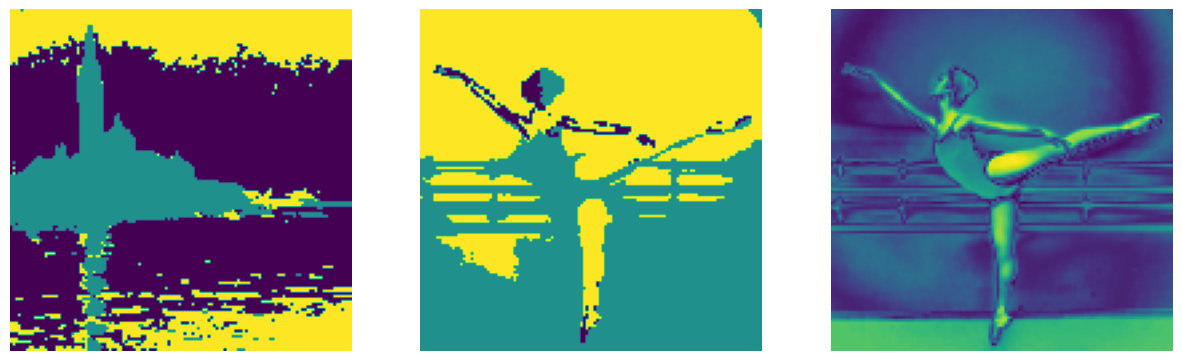

In [8]:
#clustering of style image
n_clusters=3

from sklearn.cluster import KMeans

style_img_flat = style_img.reshape((-1,3))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(style_img_flat)

cluster_labels = kmeans.labels_.reshape((imsize,imsize))
cluster_centers = kmeans.cluster_centers_

# distance of content image to cluster centers

distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
print("Distance array shape : ",distance_array.shape)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances


#greedy assignement
greedy_assignments = np.argmin(distance_array,axis=0)
distance_img = np.zeros((imsize,imsize),dtype=np.float32)
print("Distance image shape : ",distance_img.shape)

for i, cluster_center in enumerate(cluster_centers):
    mask = (greedy_assignments == i)
    distance_img[mask] = distance_array[i][mask]

plot_3_images(cluster_labels, greedy_assignments, distance_img)

Initial energy :  5151.8757783174515


  0%|          | 0/1000 [00:00<?, ?it/s]

Final energy :  5140.151110142469
Mean number of fails :  165.83333333333334


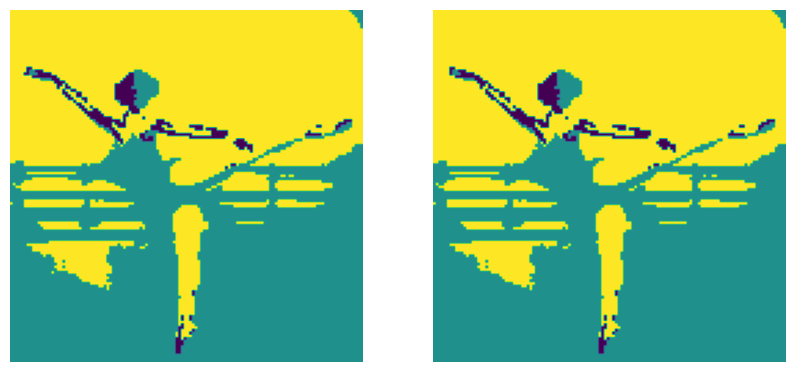

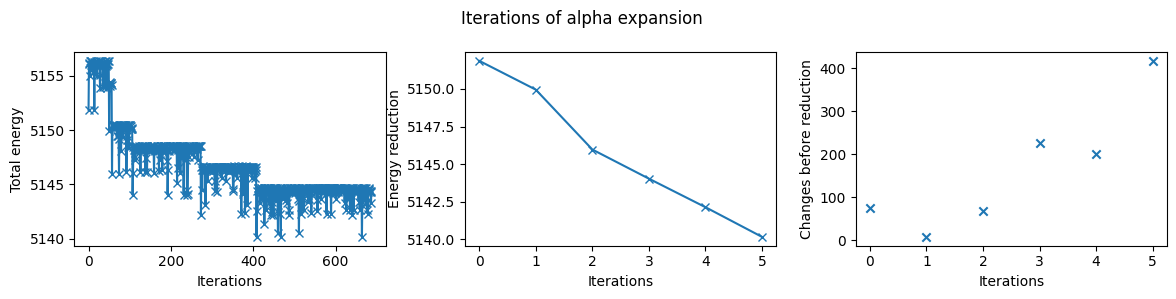

In [24]:
#stochastic expansion

beta = 1
max_iter = 1000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_stochastic(distance_array.transpose(1,2,0), greedy_assignments, max_iter=max_iter, beta=beta)

print("Mean number of fails : ",np.mean(fail_counts))

plot_2_images(greedy_assignments, assignments)
gc.plot_energy(energies, computed_energies, fail_counts)

Initial energy :  5151.8757783174515


  0%|          | 0/500 [00:00<?, ?it/s]

Final energy :  5141.399928957224
Mean number of fails :  70.57142857142857


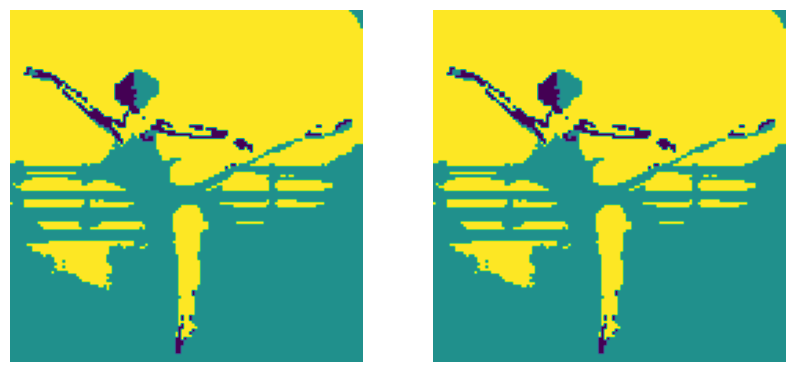

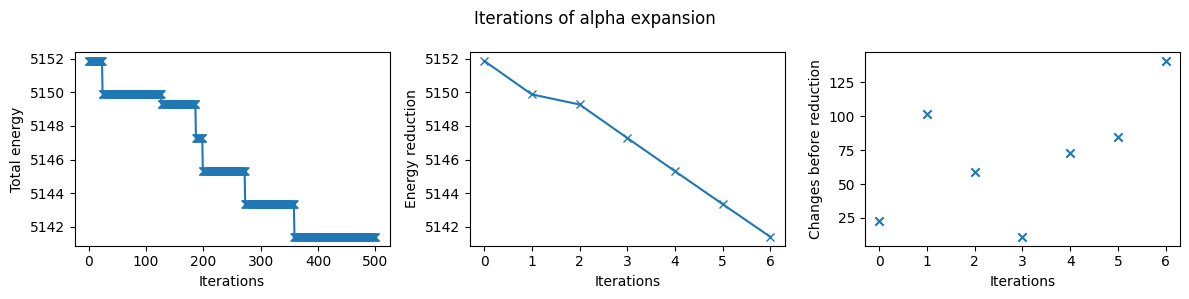

In [26]:
#greedy expansion

beta = 1
max_iter = 500

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_greedy(distance_array.transpose(1,2,0), greedy_assignments, max_iter=max_iter, beta=beta)

print("Mean number of fails : ",np.mean(fail_counts))

plot_2_images(greedy_assignments, assignments)
gc.plot_energy(energies, computed_energies, fail_counts)


Beta :  0.01


  0%|          | 0/9 [00:00<?, ?it/s]

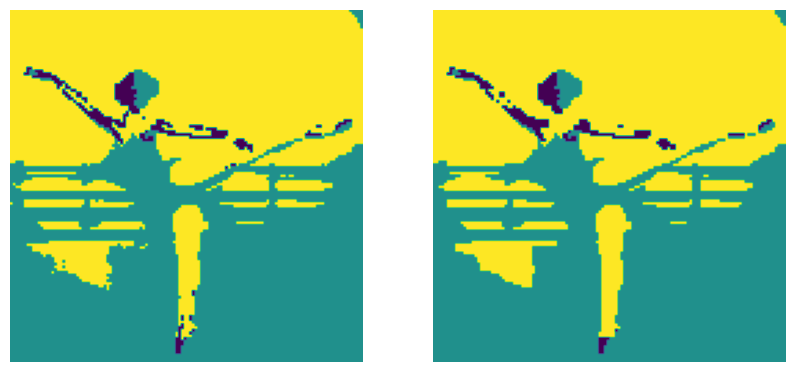

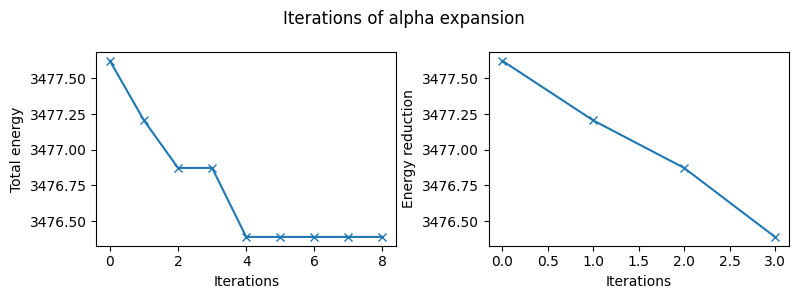


Beta :  0.1


  0%|          | 0/9 [00:00<?, ?it/s]

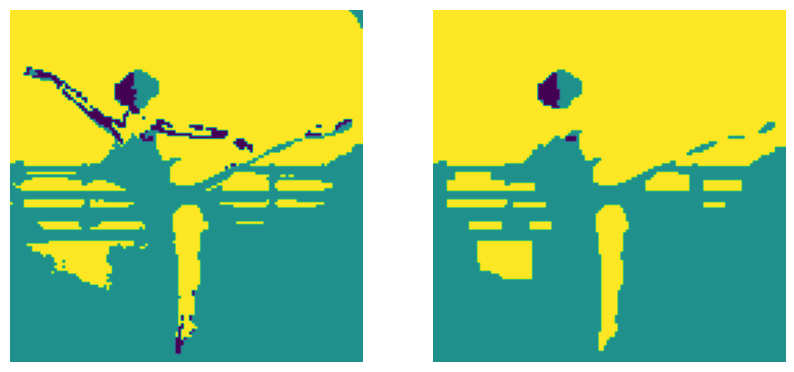

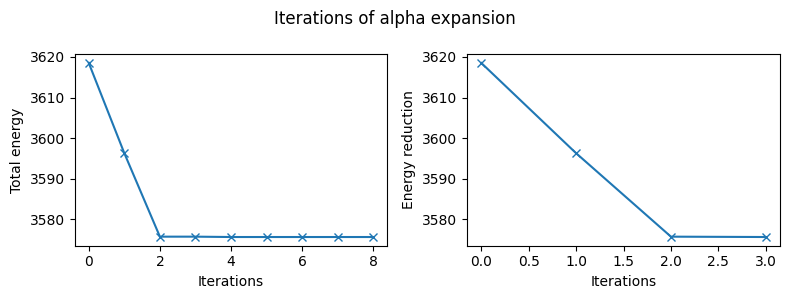


Beta :  1


  0%|          | 0/9 [00:00<?, ?it/s]

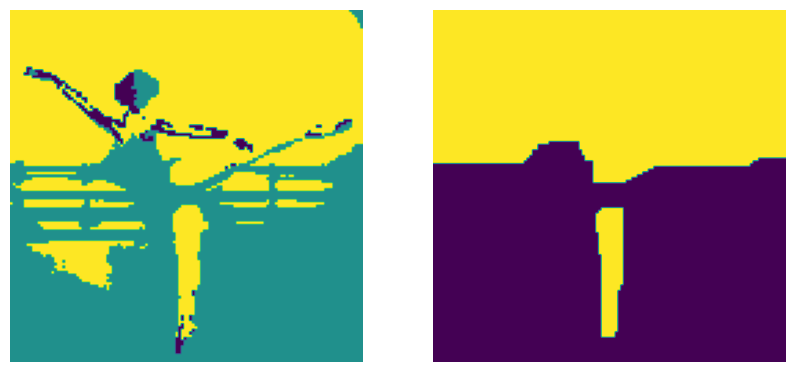

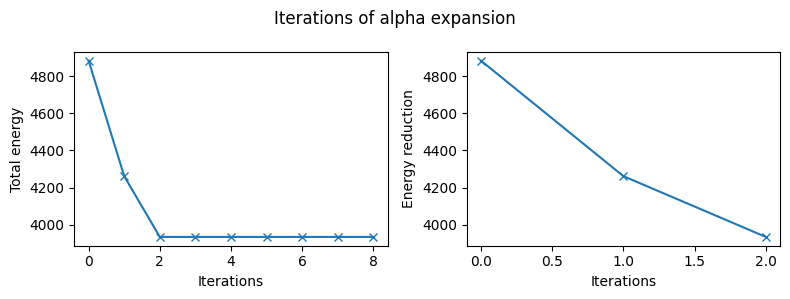

In [11]:
for beta in [1e-2,1e-1,1]:
  print("")
  print("Beta : ", beta)

  assignments, energies, computed_energies = gc.alpha_expansion(distance_array.transpose(1,2,0), greedy_assignments, max_cycles=3, beta=beta)

  plot_2_images(greedy_assignments, assignments)
  gc.plot_energy(energies, computed_energies)


Beta :  0.01
Done in 0.020235430999946402 s


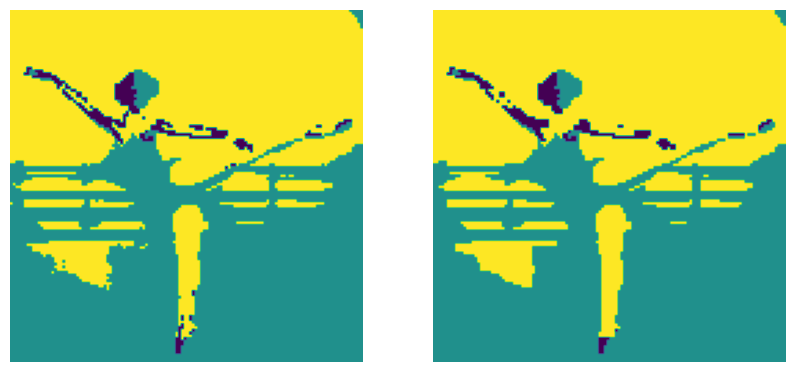


Beta :  0.1
Done in 0.06442613500030347 s


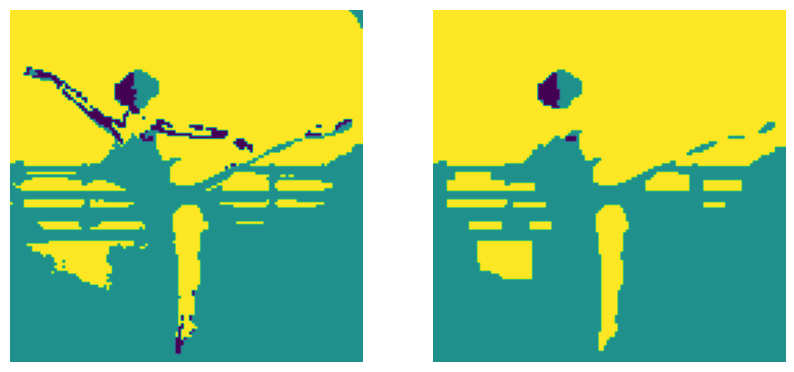


Beta :  1
Done in 0.052721999999903346 s


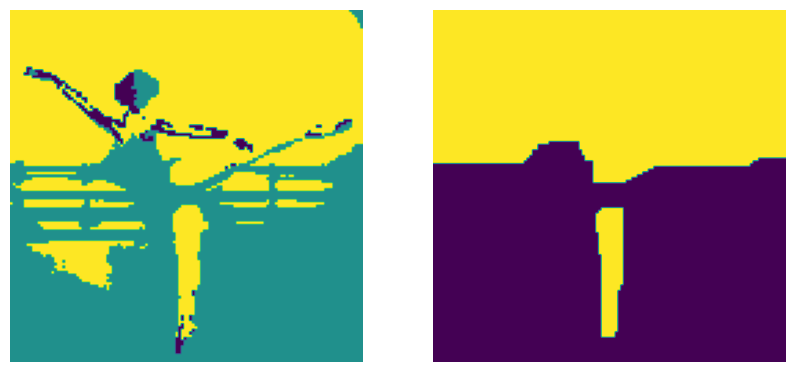

In [29]:
for beta in [1e-2,1e-1,1]:
  print("")
  print("Beta : ", beta)

  smooth_term = beta * (1 - np.eye(n_clusters))
  data_term = distance_array.transpose(1,2,0).copy().astype(np.double)

  t1 = perf_counter()
  labels = aexpansion_grid(data_term, smooth_term, max_cycles=None)
  t2 = perf_counter()
  print(f"Done in {(t2-t1)} s")

  plot_2_images(greedy_assignments, labels)

## Style transfer onf RGB space

[(9329, 3), (2924, 3), (4131, 3)]


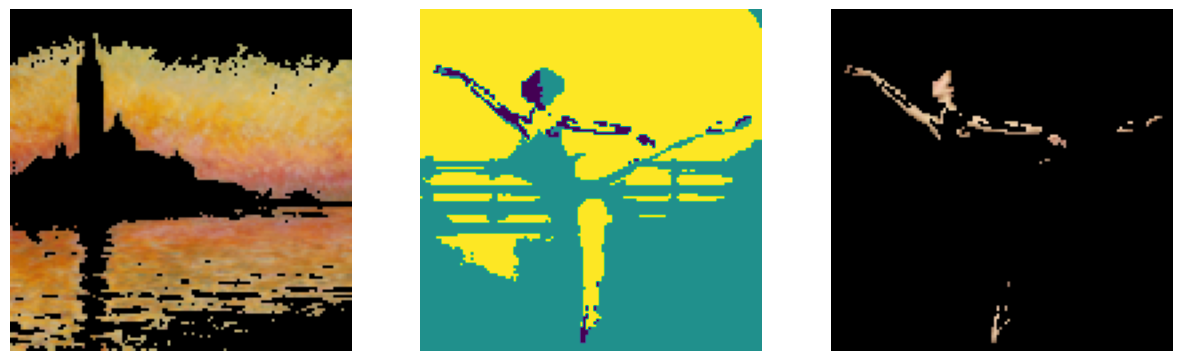

In [31]:
cluster_list = [style_img[cluster_labels == i] for i in range(n_clusters)]
print([cluster_list[i].shape for i in range(n_clusters)])

cluster_0_style_mask = (cluster_labels == 0)
cluster_0_content_mask = (greedy_assignments == 0)

plot_3_images((style_img.transpose(2,0,1) * cluster_0_style_mask).transpose(1,2,0), greedy_assignments,(content_img.transpose(2,0,1) * cluster_0_content_mask).transpose(1,2,0))

bon ça se remet à pas marcher lol mais dtf on change le repo donc balec

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Transfered features shape :  torch.Size([3, 128, 128])


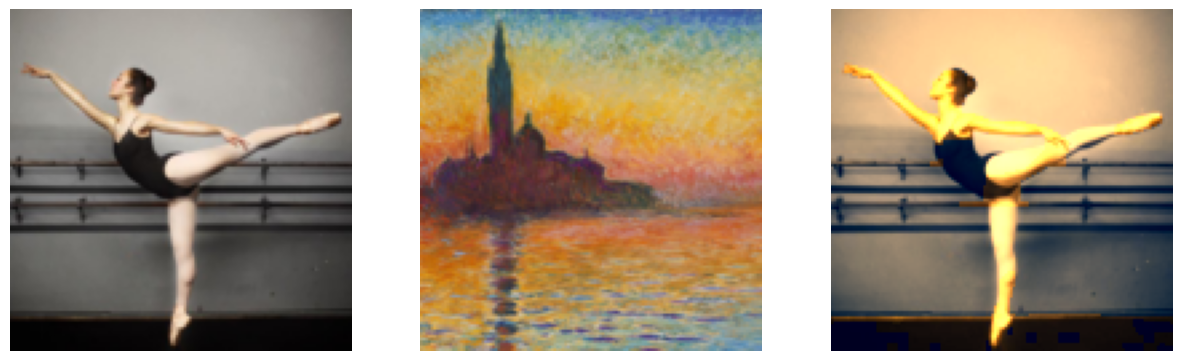

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Transfered features shape :  torch.Size([3, 128, 128])


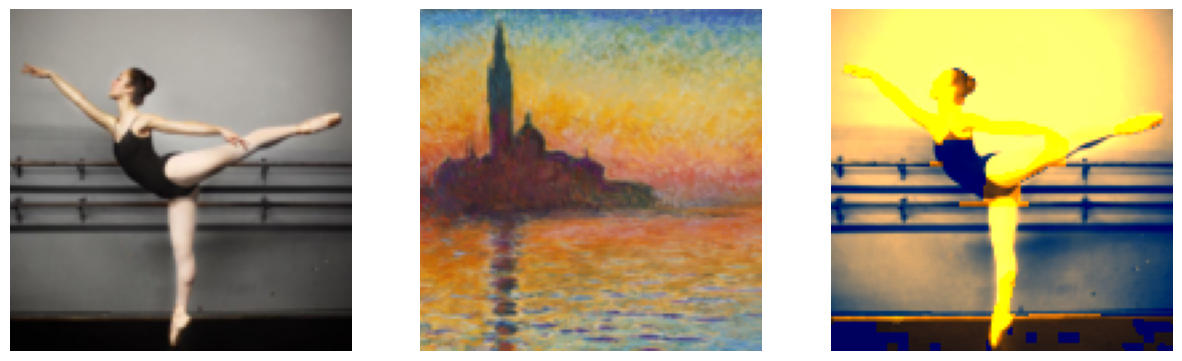

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Transfered features shape :  torch.Size([3, 128, 128])


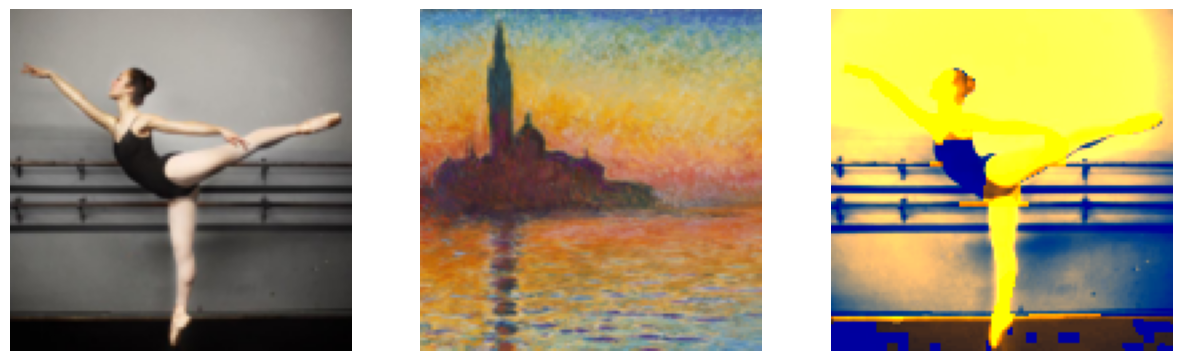

In [12]:
#pymaxflow with different alphas
for alpha in [0.1,0.3,0.5]:
  transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=alpha, lambd=0.01, k=3)
  print("Transfered features shape : ",transfered_features.shape)
  plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

In [10]:
#pymaxflow with euclidiean dist
transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=0.3, lambd=0.01, k=3, distance="euclidean")
print("Transfered features shape : ",transfered_features.shape)
plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (16384,3) (3,3) 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

Transfered features shape :  torch.Size([3, 128, 128])


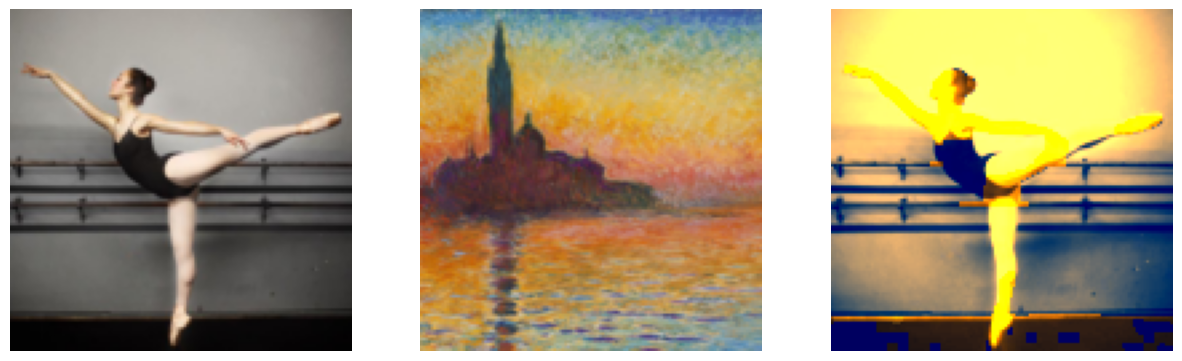

In [11]:
#local alpha expansion
transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=0.3, lambd=0.01, k=3, expansion="local")
print("Transfered features shape : ",transfered_features.shape)
plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

## Using feature encoding

In [ ]:
#VGG ?